In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

In [2]:
%matplotlib inline

In [3]:
import pickle

In [4]:
import os

In [5]:
f = os.path.join('cs231n/datasets/cifar-10-batches-py', 'data_batch_1')
print(f)

cs231n/datasets/cifar-10-batches-py/data_batch_1


In [12]:
data_all = [None]*2
data = []
labels = []
for i in range(1,3):
    with open("../data/CIFAR-10/data_batch_%d" % i, 'rb') as db:
        data_all = pickle.load(db, encoding='bytes')
        data.extend(data_all[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8"))
        labels.extend(data_all[b'labels'])

data = np.array(data)
labels = np.array(labels)
print(data.shape)        

(20000, 32, 32, 3)


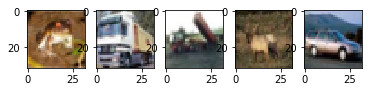

In [13]:
for i in range(5):
    image = data[i]
    plt.subplot(1,5,i+1)
    plt.imshow(image)

In [14]:
test_data = []
test_labels = []
with open("../data/CIFAR-10/test_batch",  'rb') as db:
    td = pickle.load(db, encoding='latin1')
    test_data.extend(td['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8"))
    test_labels.extend(td['labels'])

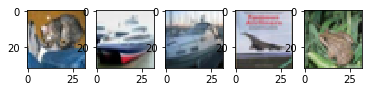

In [15]:
for i in range(5):
    image = test_data[i]
    plt.subplot(1,5,i+1)
    plt.imshow(image)

In [16]:
# Define and train model
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
keep_prob = tf.placeholder(tf.float32)


def Model(x, y, keep_prob):
    
    #
    # Create TF Variables
    #
    #Convolution layers
    wconv1 = tf.get_variable('wconv1', [3,3, 3, 16])
    bconv1 = tf.get_variable('bconv1', [16])

    #Add BatchNormalization layer between conv layers
    conv_bn_gamma = tf.get_variable('conv_bn_gamma', shape=[16])
    conv_bn_beta = tf.get_variable('conv_bn_beta', shape=[16])

    wconv2 = tf.get_variable('wconv2', [3,3,16,128])
    bconv2 = tf.get_variable('bconv2', [128])
    
    
    #affine layers
    fc_w1 = tf.get_variable('fc_w1', [32*32*128, 100])
    fc_b1 = tf.get_variable('fc_b1', [100])

    fc_w2 = tf.get_variable('fc_w2', [100, 10])
    fc_b2 = tf.get_variable('fc_b2', [10])
    
    
    #Add BatchNormalization layer between conv layers
    fc_bn_gamma = tf.get_variable('fc_bn_gamma', shape=[100])
    fc_bn_beta = tf.get_variable('fc_bn_beta', shape=[100])
    
    
    
    #
    # Define Graph Topology
    #
    c1_out = tf.nn.conv2d(x, wconv1, strides=[1,1,1,1], padding='SAME') + bconv1
    c1_out = tf.nn.relu(c1_out)

    mean, var = tf.nn.moments(c1_out, axes=[0,1,2], keep_dims=False)
    conv_bn = tf.nn.batch_normalization(c1_out, mean, var, conv_bn_gamma, conv_bn_beta, 1e-6)
    
    #c1_pool = tf.layers.max_pooling2d(inputs=conv_bn, pool_size=[2,2], strides=2)  

    
    c2_out = tf.nn.conv2d(conv_bn, wconv2, strides=[1,1,1,1], padding="SAME") + bconv2
    c2_out = tf.nn.relu(c2_out)
                                     



    c2_flat = tf.reshape(c2_out, shape=[-1, (32*32*128)])
    
    fc1_out = tf.matmul(c2_flat, fc_w1) + fc_b1
    fc1_out = tf.nn.relu(fc1_out)

    mean, var = tf.nn.moments(fc1_out, axes=[0], keep_dims=True)
    fc_bn = tf.nn.batch_normalization(fc1_out, mean, var, fc_bn_gamma, fc_bn_beta, 1e-6)


    h_fc1_drop = tf.nn.dropout(fc_bn, keep_prob)
    logits = tf.matmul(h_fc1_drop, fc_w2) + fc_b2
    
    predictions = tf.nn.softmax(logits)
    return logits, predictions


logits, y_out = Model(x, y, 0.6)    
#predicted_class = tf.argmax(predictions, axis=1)
    
total_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, 10), logits=logits)
mean_loss = tf.reduce_mean(total_loss)
    
optimizer = tf.train.AdamOptimizer(4e-3).minimize(mean_loss)

#correct_prediction = tf.equal(predicted_class, y)
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    



In [ ]:
def train(epochs, predictions, mean_loss, optimizer=None, feed_dict_provided=None, print_every=100):
        predicted_class = tf.argmax(predictions, axis=1)
        correct_prediction = tf.equal(predicted_class, y)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        fetches = [mean_loss, correct_prediction, optimizer]
        
        if optimizer is None:
            fetches[-1] = accuracy
               
        
        losses = []
        for e in range(epochs):
            losses = []
            correct = 0
            for i in range(int(math.ceil(data.shape[0]/batch_size))):
                
                offset = (i*batch_size)%data.shape[0]
                
                batch_idx = np.random.randint(data.shape[0], size=batch_size)
                x_batch = data[offset:offset+batch_size]
                y_batch = labels[offset:offset+batch_size]
                keepProb = 0.5
                
                if feed_dict_provided is None:
                    feed_dict ={ x: x_batch, y: y_batch, keep_prob: keepProb}
                else:
                    feed_dict = feed_dict_provided

                l, correct_pred, _ =sess.run(fetches, feed_dict)
            
                losses.append(l)
                correct += np.sum(correct_pred)
                
            print("epoch: ", e+1)                        
            plt.plot(losses)
            plt.grid(True)
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
            total_loss = np.sum(losses) / data.shape[0]
            total_correct = correct/data.shape[0]
        return total_loss, total_correct 
            
    

In [ ]:
loss_total = None
with tf.Session() as sess:
    with tf.device("/gpu:0"):
        sess.run(tf.global_variables_initializer())
        batch_size=250
        
        train_loss, corr = train(10, y_out, mean_loss,optimizer)
        loss_total = train_loss
        
        test_total, test_acc = train(1, y_out, mean_loss, feed_dict_provided={x: test_data, y: test_labels, keep_prob:1})
        